In [1]:
from torch.utils.tensorboard import SummaryWriter

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

# Dataset

In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


In [4]:
transform_with_mask = v2.Compose(
    [
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.ElasticTransform(100, 10),
        v2.RandomResizedCrop(256, scale=(0.3, 0.8)),
    ]
)

transoforms = v2.Compose(
    [
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
train_transforms = v2.Compose(
    [
        v2.ColorJitter(brightness=0.1),
        transoforms
    ]
)

unorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, folder_path, transform_with_mask=None, transforms=None):
        self.image_paths = [
            os.path.join(folder_path, file)
            for file in os.listdir(folder_path)
            if "_" not in file
        ]
        self.transforms = transforms
        self.transform_with_mask = transform_with_mask
        self.outline_paths = [file[:-4] + "_outline.png" for file in self.image_paths]

        self.images = []
        self.outlines = []
        for image_path in self.image_paths:
            self.images.append(
                cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) / 255
            )
        self.images = torch.Tensor(np.array(self.images)).permute(0, 3, 1, 2)

        for outline_path in self.outline_paths:
            self.outlines.append(
                cv2.cvtColor(cv2.imread(outline_path), cv2.COLOR_BGR2RGB) / 255
            )
        self.outlines = torch.Tensor(np.array(self.outlines)).permute(0, 3, 1, 2)

        self.joined = torch.cat([self.images, self.outlines], dim=1).to(device="cuda")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.joined[idx]
        if self.transform_with_mask is None:
            transformed = img
        else:
            transformed = self.transform_with_mask(img)
        if isinstance(idx, int):
            img, target = transformed[:3],  transformed[3:]
        else:
            img, target = transformed[:, :3], transformed[:, 3:]
        
        if self.transforms:
            img = self.transforms(img)
        return img, target

In [6]:
class SegmentationDataloader(DataLoader):
    def __init__(
        self,
        ds,
        batch_size,
        shuffle=True,
        use_rand_resize=True,
        random_resize_kwargs={"min_size": 400, "max_size": 640},
    ):
        self.ds = ds
        self.batch_size = batch_size
        # self.batch_transform = batch_transform
        self.shuffle = shuffle
        self.use_rand_resize = use_rand_resize
        self.indexes = np.arange(len(self.ds)) // self.batch_size
        self.len = self.indexes.max()
        self.resizer = v2.RandomResize(**random_resize_kwargs)

    def __len__(self):
        return self.len

    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
        for i in range(self.len):
            
            img, mask = (self.ds[self.indexes == i])
            if self.use_rand_resize:
                resized = self.resizer(torch.cat([img, mask], dim=1))
                img, mask = resized[:, :3], resized[:, 3:]
            yield img, mask

In [7]:
ds = SegmentationDataset(
    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\train",
    transform_with_mask,
    train_transforms,
)
dl = SegmentationDataloader(ds, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


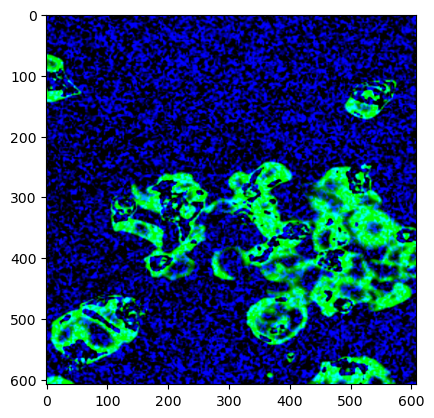

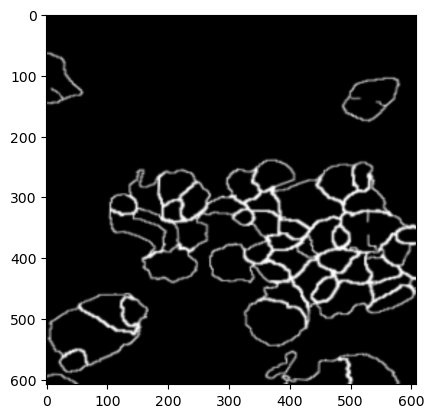

In [8]:
batch = next(iter(dl))
img, mask = batch[0][0].cpu(), batch[1][0].cpu()
plt.imshow(img.permute(1, 2, 0).detach().numpy())
plt.show()
plt.imshow(mask.permute(1, 2, 0).detach().numpy())
plt.show()

# Архитектура модели должна быть схода с U-Net, при этом в качестве contracting path требуется использовать любую предобученную свёрточную модель.
# Модель должна позволять выполнять предсказания для изображений разного размера.

In [9]:
logdir = os.path.join(
    "logs/segmentation/resnet", "use_grad" 
)
writer = SummaryWriter(log_dir=logdir)


In [10]:
class ResUnet(torch.nn.Module):
    def create_upsampling_block(input_chanels, output_chanels, upsample=True):
        initila_part = (
            torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=2),
            )
            if upsample
            else torch.nn.Identity()
        )
        return torch.nn.Sequential(
            initila_part,
            torch.nn.BatchNorm2d(input_chanels),
            torch.nn.Conv2d(input_chanels, output_chanels, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(output_chanels),
            torch.nn.Conv2d(output_chanels, output_chanels, 3, padding=1),
            torch.nn.ReLU(),
        )

    def __init__(self):
        super().__init__()
        self.contracting_path = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # self.contracting_path.requires_grad_(False)
        self.up_block1 = ResUnet.create_upsampling_block(512, 256)
        self.up_block2 = ResUnet.create_upsampling_block(512, 128)
        self.up_block3 = ResUnet.create_upsampling_block(256, 64)
        self.up_block4 = ResUnet.create_upsampling_block(128, 64)

        self.conv_transpose_1 = torch.nn.ConvTranspose2d(64, 64, 3)
        self.segment_head = torch.nn.Sequential(
            torch.nn.Conv2d(64, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 1, 3, padding=1),
            torch.nn.Sigmoid(),
        )

    def forward(self, X):
        X_c = self.contracting_path.conv1(X)
        X_1 = self.contracting_path.layer1(X_c)
        X_2 = self.contracting_path.layer2(X_1)
        X_3 = self.contracting_path.layer3(X_2)
        # input = 256, output = 512
        X_4 = self.contracting_path.layer4(X_3)
        # input = 512, output = 256
        X_5 = self.up_block1(X_4)
        if X_5.shape[-1] > X_3.shape[-1]:
            X_5 = X_5[..., :-1, :-1]
        X_5 = torch.cat([X_3, X_5], dim=1)

        X_6 = self.up_block2(X_5)
        if X_6.shape[-1] > X_2.shape[-1]:
            X_6 = X_6[..., :-1, :-1]
        X_6 = torch.cat([X_2, X_6], dim=1)

        X_7 = self.up_block3(X_6)
        if X_7.shape[-1] > X_1.shape[-1]:
            X_7 = X_7[..., :-1, :-1]
        X_7 = torch.cat([X_1, X_7], dim=1)

        X_8 = self.up_block4(X_7)
        if X_8.shape[-1] > X_c.shape[-1]:
            X_8 = X_8[..., :-1, :-1]

        X_8 = self.conv_transpose_1(X_8)[..., :-1, :-1]
        if X_8.shape[-1] > X.shape[-1]:
            X_8 = X_8[..., 1:, 1:]

        ret = self.segment_head(X_8)

        return ret

In [11]:
model = ResUnet().to(device="cuda")

In [12]:
import torchsummary

In [13]:
torchsummary.summary(model, (3, 640, 640,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           9,408
            Conv2d-2         [-1, 64, 320, 320]          36,864
       BatchNorm2d-3         [-1, 64, 320, 320]             128
              ReLU-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 64, 320, 320]          36,864
       BatchNorm2d-6         [-1, 64, 320, 320]             128
              ReLU-7         [-1, 64, 320, 320]               0
        BasicBlock-8         [-1, 64, 320, 320]               0
            Conv2d-9         [-1, 64, 320, 320]          36,864
      BatchNorm2d-10         [-1, 64, 320, 320]             128
             ReLU-11         [-1, 64, 320, 320]               0
           Conv2d-12         [-1, 64, 320, 320]          36,864
      BatchNorm2d-13         [-1, 64, 320, 320]             128
             ReLU-14         [-1, 64, 3

In [14]:
writer.add_graph(model, next(iter(dl))[0])

C:\Users\uiif\AppData\Local\Temp\ipykernel_14640\2959012679.py:50: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X_5.shape[-1] > X_3.shape[-1]:
C:\Users\uiif\AppData\Local\Temp\ipykernel_14640\2959012679.py:55: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X_6.shape[-1] > X_2.shape[-1]:
C:\Users\uiif\AppData\Local\Temp\ipykernel_14640\2959012679.py:60: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the futu

In [15]:
rets = model(batch[0]).cpu()

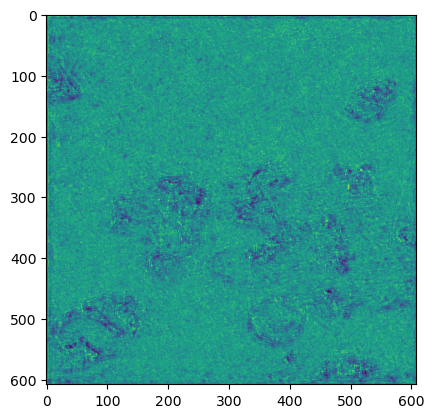

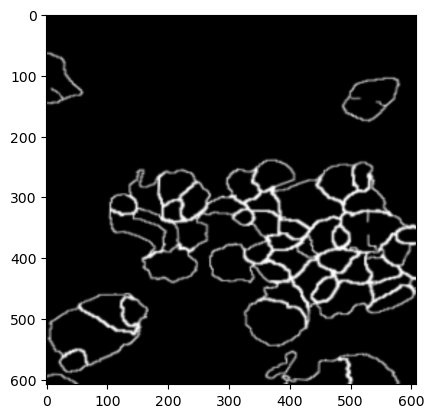

In [16]:
plt.imshow(rets[0].permute(1, 2, 0).detach().numpy())
plt.show()
plt.imshow(batch[1][0].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

# Требуется использовать Dice Loss.

In [17]:
def dice_loss(y_true, y_pred):
    interception = (y_true * y_pred).sum()
    return 1 - (2 * interception / (y_true.sum() + y_pred.sum() + 1e-10))


def iou(y_true, y_pred, treshold=0.5):
    """
    The function calculates IOU loss for multiclassification task
    Input:
        y_true: the tensor with shape (batch , width, height, classess) and true label of object,
        y_pred: the tensor with shape (batch , width, height, classess) and predicted label of object
    """

    upper = (y_true * y_pred > treshold).sum()
    lower = (y_true + y_pred > treshold).sum() - upper + 1e-10

    return 1 - upper / lower

In [18]:
dice_loss(batch[1][0].cpu(), rets[0])

tensor(0.7436, grad_fn=<RsubBackward1>)

# Требуется реализовать следующие функции

In [19]:
def evaluate_model(path: str, model: ResUnet) -> tuple[float, float]:
    """Evaluates model on the given dataset split (i.e. 'dataset/train'). Computes Dice Loss and IOU metric.

    Arguments:
        path: path to the dataset split with input and gorund truth images
        model: model to evaluate

    Returns:
        Dice Loss and IOU metric values"""
    model.eval()
    ds = SegmentationDataset(path, transforms=transoforms)
    dl = SegmentationDataloader(ds, 3, shuffle=False, use_rand_resize=False)

    rets = []
    targets = []
    with torch.no_grad():
        for batch in dl:
            targets.append(batch[1].cpu().detach().numpy())
            rets.append(model(batch[0]).cpu().detach().numpy())
    rets = np.concatenate(rets, axis=0)
    targets = np.concatenate(targets, axis=0)
    return dice_loss(targets, rets), iou(targets, rets)


def on_one_image(batch, pred, treshold=0.5):
    pred_img = unorm(batch[0].cpu()).permute(0, 2, 3, 1).detach().numpy() * ~(
        pred[:, 0, ..., None] > treshold
    ) + np.concatenate(
        [
            pred[:, 0, ..., None] > treshold,
            np.zeros_like(batch[1].cpu()[:, 0, ..., None]),
            np.zeros_like(batch[1].cpu()[:, 0, ..., None]),
        ],
        axis=-1,
    )

    return pred_img * ~(
        batch[1].cpu().detach().numpy()[:, 0, ..., None] > 0.5
    ) + np.concatenate(
        [
            np.zeros_like(batch[1].cpu()[:, 0, ..., None]),
            batch[1].cpu()[:, 0, ..., None],
            batch[1].cpu()[:, 0, ..., None],
        ],
        axis=-1,
    )


# batch[1].cpu()[:, 0, ..., None]

# def on_one_image(batch, pred, treshold=0.5):
#     return np.concatenate(
#         [
#             pred[:, 0, ..., None] > treshold,
#             batch[1].cpu()[:, 0, ..., None],
#             np.zeros_like(batch[1].cpu()[:, 0, ..., None]),
#         ],
#         axis=-1,
#     )


def diff_image(batch, pred):
    return batch[1].cpu()[:, 0] - pred[:, 0]


def draw_predic(batch, pred, treshold=0.5):
    mask = pred > treshold
    ret = (unorm(batch[0].cpu()) * ~mask).permute(
        0, 2, 3, 1
    ).detach().numpy() + np.concatenate(
        [
            np.zeros_like(batch[1].cpu()[:, 0, ..., None]),
            mask[:, 0, ..., None],
            np.zeros_like(batch[1].cpu()[:, 0, ..., None]),
        ],
        axis=-1,
    )

    return ret


def plot_predictions(
    path: str, model: ResUnet, nrows: int = 2, ncols: int = 2, how_to_plot=diff_image
):
    """Plots model predictions (and ground truths) on a number of images randomly selected from the given dataset split. The images are plotted on a grid with `nrows` rows and `ncols` columns.
    Red True value
    Green Predicted value
    Arguments:
        path: path to the dataset split with input and gorund truth images
        model: model to use for predictions
        nrows: number of grid rows
        ncols: number of grid columns"""
    ds = SegmentationDataset(path, transforms=transoforms)
    dl = SegmentationDataloader(ds, nrows, shuffle=False, use_rand_resize=False)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
    with torch.no_grad():
        for i, batch in enumerate(dl):
            if i >= ncols:
                break
            pred = model(batch[0]).cpu().detach().numpy()

            imgs = how_to_plot(batch, pred)
            for j, im in enumerate(imgs):
                p = ax[j][i].imshow(im, vmin=-1, vmax=1)
                if len(imgs.shape) == 3:
                    fig.colorbar(p)

    plt.show()

In [20]:
evaluate_model(
    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\val", model
)

(0.7582930716820935, 0.9790701610604333)

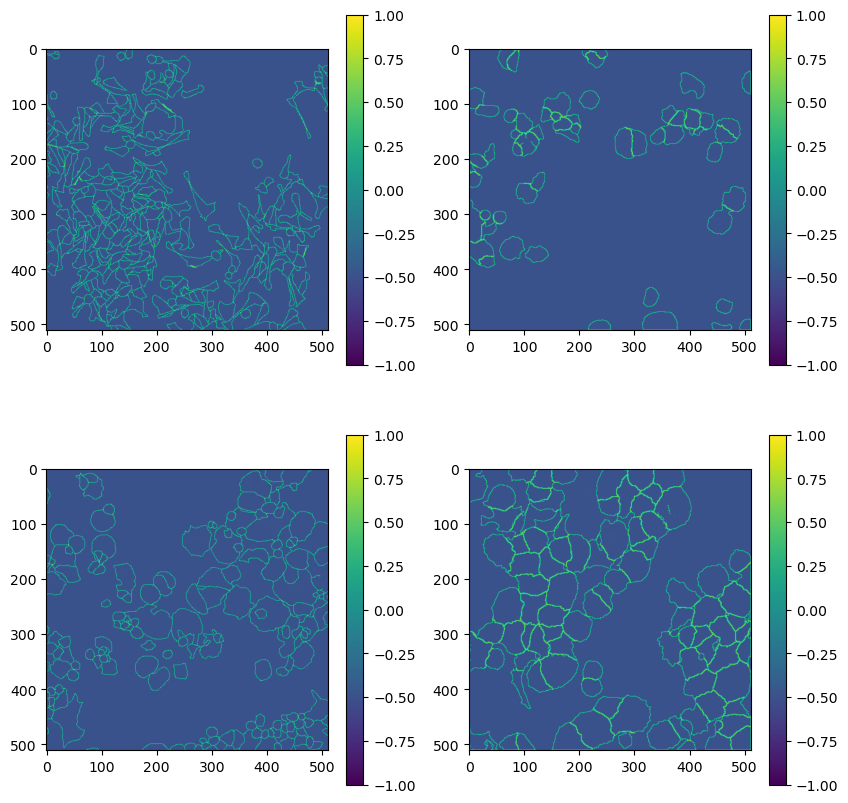

In [21]:
plot_predictions(
    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\val", model
)

# Train loop

In [22]:
optim = torch.optim.Adam(model.parameters())
loss = dice_loss

In [23]:
for i in tqdm(range(50)):
    for img, target in dl:
        optim.zero_grad()
        model.train()
        pred = model(img)
        loss_val = loss(target, pred)
        loss_val.backward()
        optim.step()

    writer.add_scalars(
        "train",
        dict(
            zip(
                (
                    "dice",
                    "iou",
                ),
                evaluate_model(
                    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\train",
                    model,
                ),
            )
        ),
        i
    )
    writer.add_scalars(
        "val",
        dict(
            zip(
                (
                    "dice",
                    "iou",
                ),
                evaluate_model(
                    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\val",
                    model,
                ),
            )
        ),
        i
    )

100%|██████████| 50/50 [29:19<00:00, 35.19s/it]


In [24]:
torch.save(model, "segmentation.pt")

In [25]:
model= torch.load("segmentation.pt")

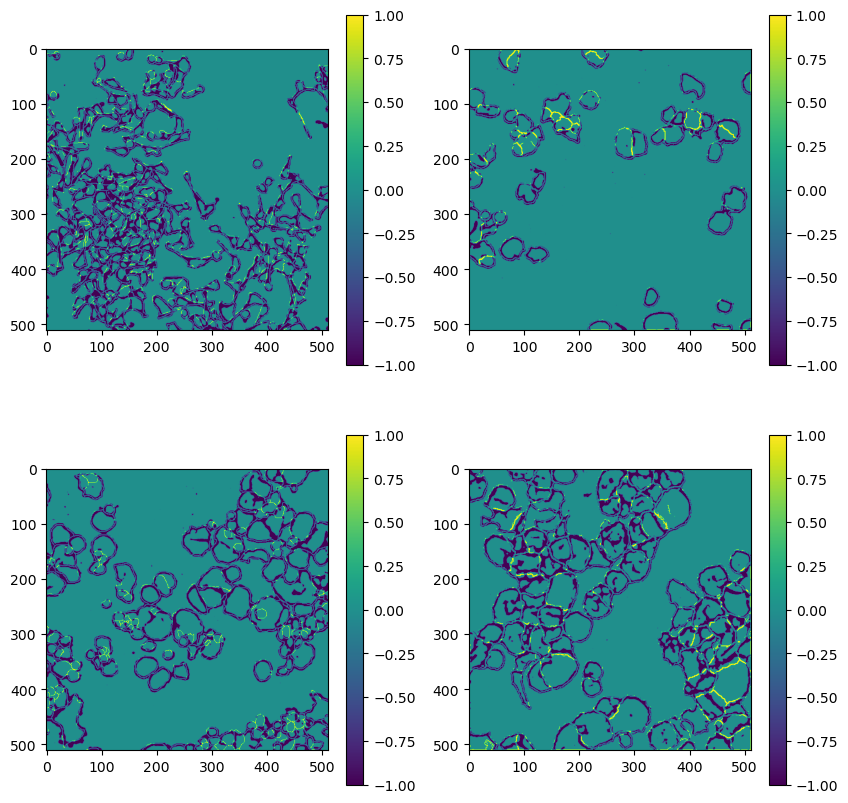

In [26]:
plot_predictions(
    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\val", model
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


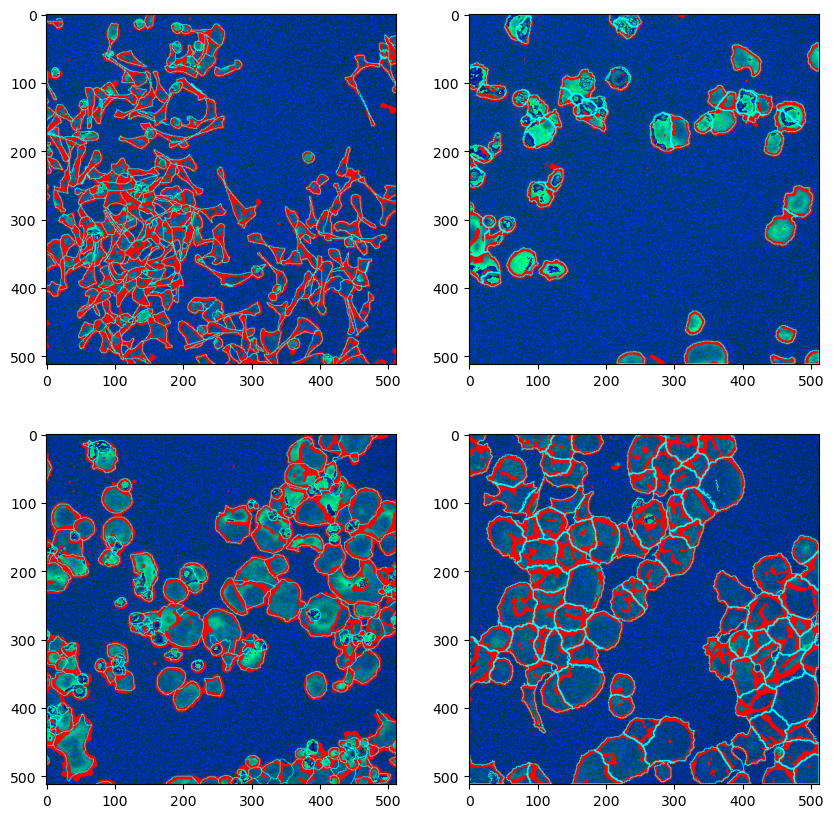

In [27]:
plot_predictions(
    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\val", model, how_to_plot=on_one_image
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


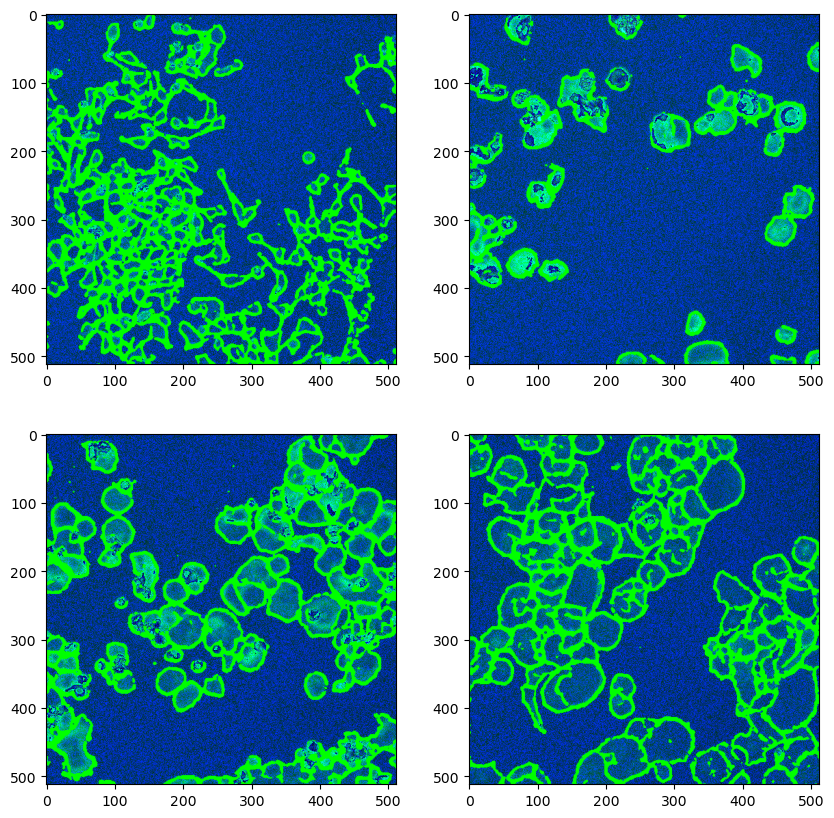

In [28]:
plot_predictions(
    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\val",
    model,
    how_to_plot=draw_predic,
)


In [29]:
(
    evaluate_model(
        "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\train", model
    ),
    evaluate_model(
        "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\segmentation\\val", model
    ),
)


((0.3167276305691067, 0.7594279174124254),
 (0.2820770588718602, 0.7334183708383402))